In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from utils import get_data, draw_ellipse

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
X, y, metadata, variables = get_data('wine_quality')

In [3]:
y.value_counts(normalize=True)

quality
6          0.436509
5          0.329075
7          0.166077
4          0.033246
8          0.029706
3          0.004618
9          0.000770
Name: proportion, dtype: float64

In [4]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# Train the Expectation Maximisation

In [5]:
RANDOM_STATE = 42
N_JOBS = -1
VERBOSE = 4

scaler = StandardScaler()

# clus = GaussianMixture(n_init=100, init_params='k-means++', random_state=RANDOM_STATE, covariance_type='full')
clus = GaussianMixture(random_state=RANDOM_STATE)
clus_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('model', clus)
])


In [6]:
# clus_pipeline.set_params(model__n_components=3)
# clus_pipeline.fit(X_train)
# clus_pipeline.named_steps['model'].means_
# clus_pipeline.named_steps['model'].score(X_train)

In [7]:
results = {}
for n_components in range(2, 20):
    print(f"---------- n_components: {n_components} ----------")
    clus_pipeline.set_params(model__n_components=n_components)
    clus_pipeline.fit(X_train)

    clus_labels = clus_pipeline.predict(X_train)
    sil_score = silhouette_score(X_train, clus_labels)
    
    results[n_components] = {'aic': clus_pipeline.named_steps['model'].aic(X_train.values),
                             'bic': clus_pipeline.named_steps['model'].bic(X_train.values),
                             'score': clus_pipeline.named_steps['model'].score(X_train.values),
                             'sil_score': sil_score,
                           }

---------- n_components: 2 ----------


---------- n_components: 3 ----------
---------- n_components: 4 ----------
---------- n_components: 5 ----------
---------- n_components: 6 ----------
---------- n_components: 7 ----------
---------- n_components: 8 ----------
---------- n_components: 9 ----------
---------- n_components: 10 ----------
---------- n_components: 11 ----------
---------- n_components: 12 ----------
---------- n_components: 13 ----------
---------- n_components: 14 ----------
---------- n_components: 15 ----------
---------- n_components: 16 ----------
---------- n_components: 17 ----------
---------- n_components: 18 ----------
---------- n_components: 19 ----------


<Axes: title={'center': 'GMM BIC - Wine Quality'}, xlabel='n_components'>

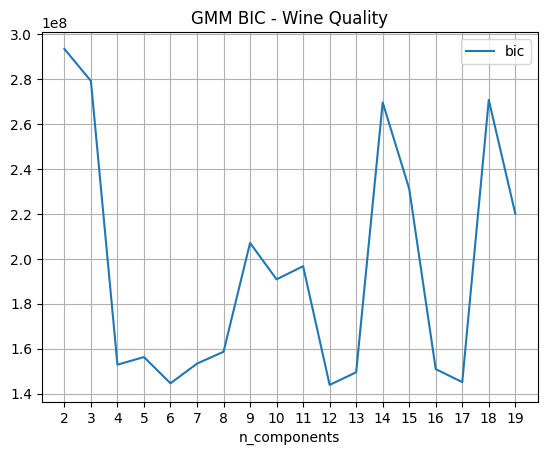

In [8]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_components', 'aic', 'bic', 'score', 'sil_score']
results_df.plot(x='n_components', y='bic',title='GMM BIC - Wine Quality', xticks=results_df['n_components'], grid=True)

<Axes: title={'center': 'GMM Silhouette score - Wine Quality'}, xlabel='n_components'>

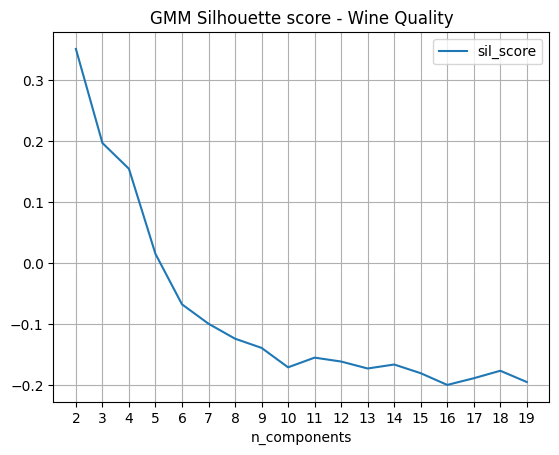

In [9]:
results_df.plot(x='n_components', y='sil_score',title='GMM Silhouette score - Wine Quality', xticks=results_df['n_components'], grid=True)

<Axes: title={'center': 'GMM score - Wine Quality'}, xlabel='n_components'>

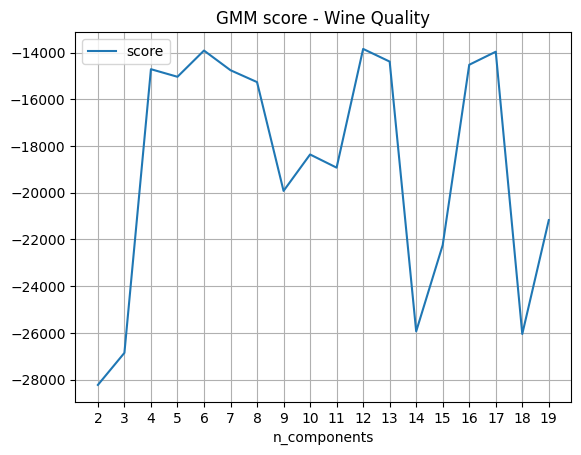

In [10]:
results_df.plot(x='n_components', y='score',title='GMM score - Wine Quality', xticks=results_df['n_components'], grid=True)

In [16]:
clus_pipeline.set_params(model__n_components=4)
label = clus_pipeline.fit_predict(X_train)
print(label.shape)

means = clus_pipeline.named_steps['model'].means_
covariances = clus_pipeline.named_steps['model'].covariances_
weights = clus_pipeline.named_steps['model'].weights_

w_factor = 0.2 / weights.max()

(5197,)


In [17]:
X_std = StandardScaler().fit_transform(X_train)
X_std

array([[-0.8715968 , -1.02564121,  0.6953355 , ..., -2.17021899,
        -0.4206092 , -0.82057522],
       [-0.24953102, -0.78430704, -0.53370718, ..., -0.42777889,
        -0.48874841,  1.53483054],
       [-0.63832213, -0.48263932,  0.76361565, ..., -0.86338891,
        -1.03386213, -1.32530502],
       ...,
       [-0.40504747, -0.90497412,  0.01253401, ..., -1.98352897,
         0.26078295,  0.02064112],
       [-0.63832213, -0.54297286,  2.88030027, ..., -0.05439887,
        -0.76130527, -1.07294012],
       [-0.1717728 , -0.60330641,  1.03673625, ..., -0.17885887,
        -0.55688763,  0.44124929]])

In [18]:
# Get two components cov for plotting
covariances_2 = covariances[:, 0:2, 0:2]
covariances_2

array([[[ 0.44759943, -0.01375489],
        [-0.01375489,  0.23160734]],

       [[ 1.83657324, -0.37512693],
        [-0.37512693,  1.01316581]],

       [[ 0.22060821,  0.003393  ],
        [ 0.003393  ,  0.23724556]],

       [[ 1.1933424 ,  0.10696047],
        [ 0.10696047,  1.62244789]]])

Text(0, 0.5, 'volatile_acidity')

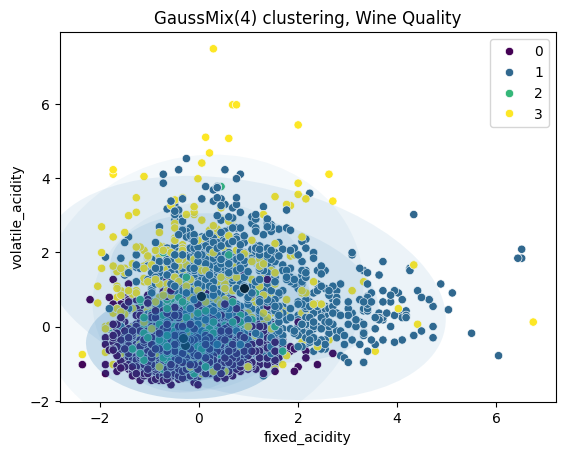

In [19]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_std[:,0], y=X_std[:,1], hue=label, palette='viridis', ax=ax)
sns.scatterplot(x=means[:,0], y=means[:,1], color='black', s=50, marker='o', ax=ax)

for pos, covar, w in zip(means, covariances_2, weights):
        draw_ellipse(pos, covar, alpha=w * w_factor)

ax.set_title("GaussMix(4) clustering, Wine Quality")
ax.set_xlabel("fixed_acidity")
ax.set_ylabel("volatile_acidity")


In [20]:
from itertools import combinations
combs = list(combinations(range(0, X_train.shape[1]), 2))
len(combs)

55

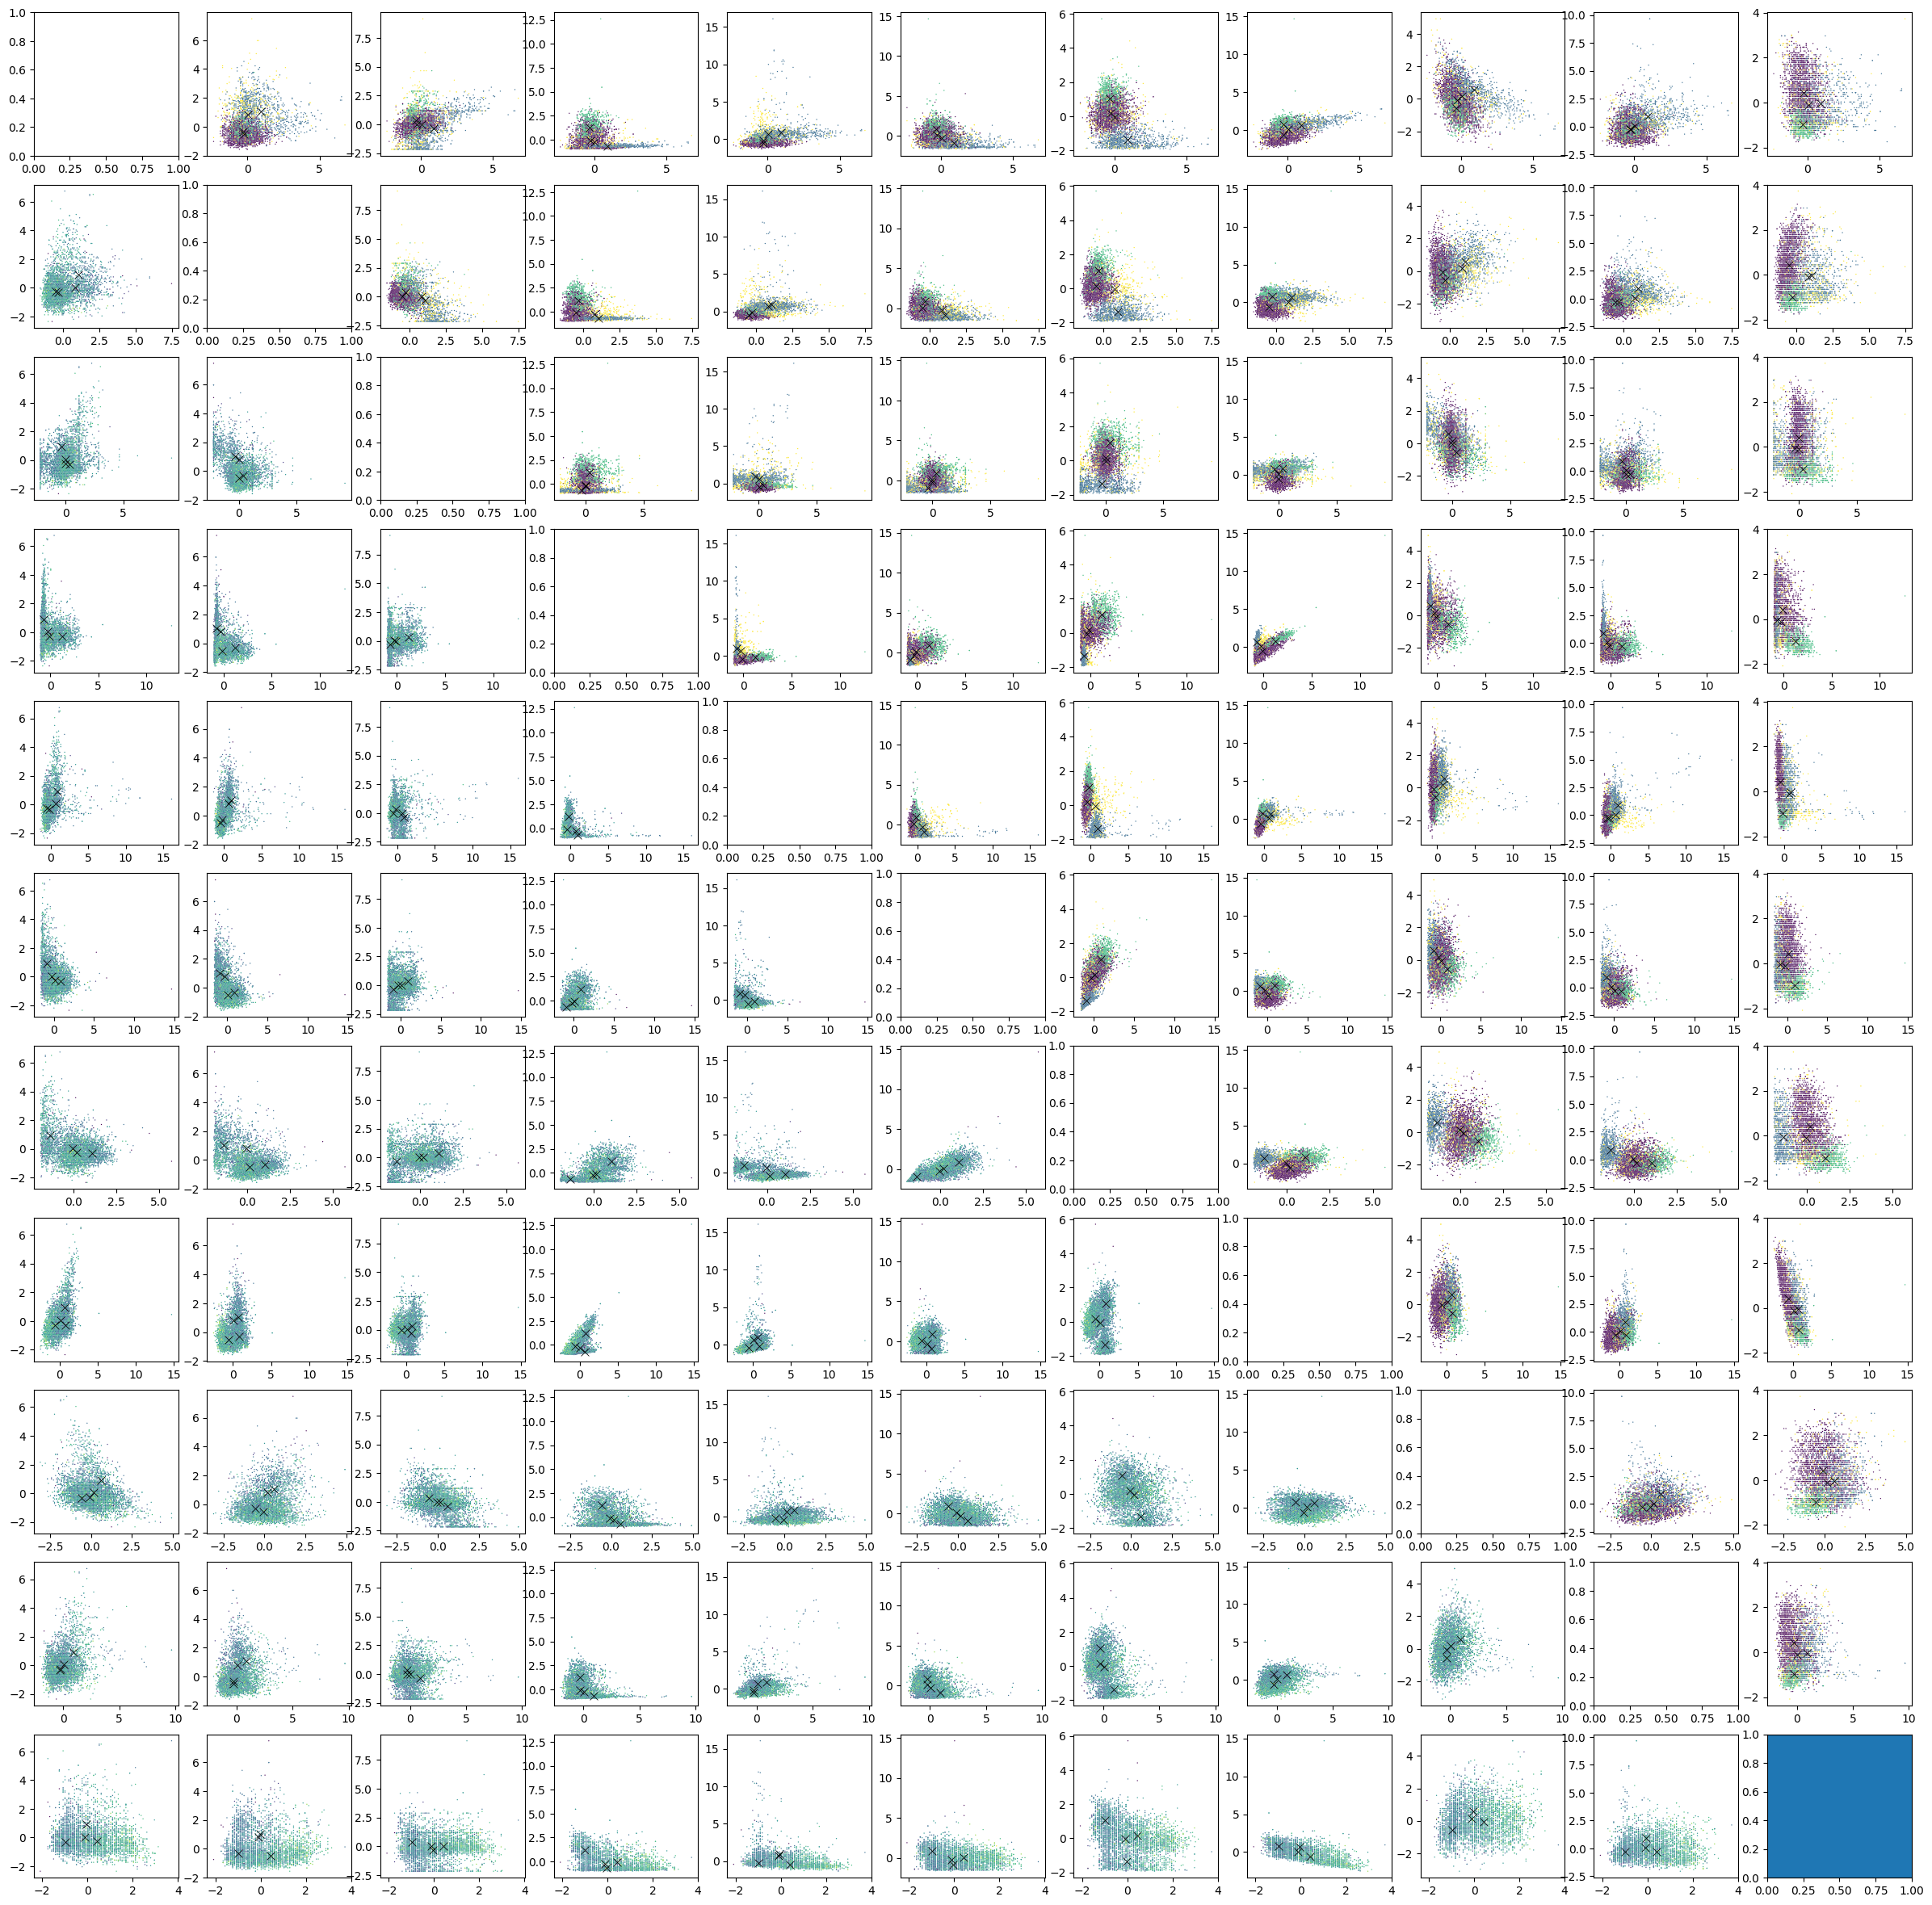

In [25]:
fig, ax = plt.subplots(X_train.shape[1], X_train.shape[1], figsize=(30, 30))
for i, j in combs:
    
    sns.scatterplot(x=X_std[:,i], y=X_std[:,j], hue=label, palette='viridis', ax=ax[i, j], legend=False, s=1)
    sns.scatterplot(x=means[:,i], y=means[:,j], color='black', s=50, marker='x', ax=ax[i, j])

    covariances_2 = covariances[:, [i, j], [i, j]]
    for pos, covar, w in zip(means, covariances_2, weights):
        draw_ellipse(pos, covar, alpha=w * w_factor)

    # ax[i, j].set_title(f"KMeans(3), Dry Beans")
    # ax[i, j].set_xlabel(X_train.columns[i])
    # ax[i, j].set_ylabel(X_train.columns[j])

    sns.scatterplot(x=X_std[:,j], y=X_std[:,i], hue=y_train.values[:, 0], palette='viridis', ax=ax[j, i], legend=False, s=1)
    sns.scatterplot(x=means[:,j], y=means[:,i], color='black', s=50, marker='x', ax=ax[j, i])
    # ax[j, i].set_title(f"KMeans(3), Dry Beans")
    # ax[j, i].set_xlabel(X_train.columns[j])
    # ax[j, i].set_ylabel(X_train.columns[i])